In [1]:
# Import the packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
# Parameters of the artificial data
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

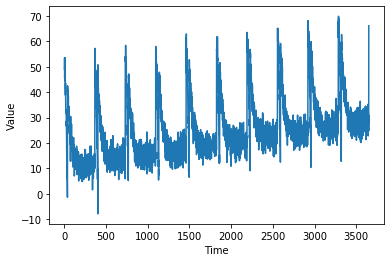

In [4]:
plot_series(time, series)

In [5]:
# Parameters of the training sets
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
# Define the model
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
    # Expand the dimension of 1
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    # First layer = Bidirectional LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # Second layer = Bidirectional LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # Dense layer
    tf.keras.layers.Dense(1),
    # Increase value by 10
    tf.keras.layers.Lambda(lambda x: x * 10.0)
])

In [10]:
# Define learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# Define the optimizer
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
# Compile the model
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])

In [11]:
history = model.fit(dataset, epochs = 25, callbacks=[lr_schedule])

Epoch 1/25
94/94 [==============================] - 21s 228ms/step - loss: 26.6684 - mae: 27.1834
Epoch 2/25
94/94 [==============================] - 11s 118ms/step - loss: 26.6240 - mae: 27.1379
Epoch 3/25
94/94 [==============================] - 12s 126ms/step - loss: 26.5669 - mae: 27.0779
Epoch 4/25
94/94 [==============================] - 12s 130ms/step - loss: 26.5057 - mae: 26.9975
Epoch 5/25
94/94 [==============================] - 12s 130ms/step - loss: 26.3990 - mae: 26.8954
Epoch 6/25
94/94 [==============================] - 11s 115ms/step - loss: 26.2802 - mae: 26.7865
Epoch 7/25
94/94 [==============================] - 11s 122ms/step - loss: 26.1792 - mae: 26.6838
Epoch 8/25
94/94 [==============================] - 12s 124ms/step - loss: 26.0786 - mae: 26.5873
Epoch 9/25
94/94 [==============================] - 11s 115ms/step - loss: 26.0011 - mae: 26.4991
Epoch 10/25
94/94 [==============================] - 11s 122ms/step - loss: 25.9159 - mae: 26.4226
Epoch 11/25
94/94 [

[1e-08, 0.0001, 0, 30]

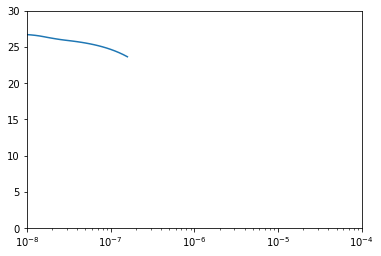

In [12]:
# Plot the loss evolution according to the learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [13]:
# WITH THE SET LEARNING RATE

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9), metrics = ["mae"])
history = model.fit(dataset, epochs = 100, verbose = 1)

Epoch 1/100
94/94 [==============================] - 22s 230ms/step - loss: 454.3103 - mae: 12.0511
Epoch 2/100
94/94 [==============================] - 14s 144ms/step - loss: 41.9711 - mae: 4.6002
Epoch 3/100
94/94 [==============================] - 18s 196ms/step - loss: 33.5976 - mae: 4.1442
Epoch 4/100
94/94 [==============================] - 19s 201ms/step - loss: 30.1115 - mae: 3.8117
Epoch 5/100
94/94 [==============================] - 19s 201ms/step - loss: 29.0714 - mae: 3.7075
Epoch 6/100
94/94 [==============================] - 18s 196ms/step - loss: 28.5248 - mae: 3.7055
Epoch 7/100
94/94 [==============================] - 19s 205ms/step - loss: 30.8455 - mae: 3.9347
Epoch 8/100
94/94 [==============================] - 20s 210ms/step - loss: 32.2771 - mae: 4.0566
Epoch 9/100
94/94 [==============================] - 19s 204ms/step - loss: 32.2342 - mae: 4.0770
Epoch 10/100
94/94 [==============================] - 19s 202ms/step - loss: 34.8838 - mae: 4.3201
Epoch 11/100
94/9

94/94 [==============================] - 12s 124ms/step - loss: 22.7924 - mae: 3.2867
Epoch 84/100
94/94 [==============================] - 12s 126ms/step - loss: 22.5589 - mae: 3.2262
Epoch 85/100
94/94 [==============================] - 12s 127ms/step - loss: 22.9028 - mae: 3.2326
Epoch 86/100
94/94 [==============================] - 12s 127ms/step - loss: 23.1294 - mae: 3.2933
Epoch 87/100
94/94 [==============================] - 12s 123ms/step - loss: 23.5279 - mae: 3.2993
Epoch 88/100
94/94 [==============================] - 12s 126ms/step - loss: 22.7117 - mae: 3.2548
Epoch 89/100
94/94 [==============================] - 12s 126ms/step - loss: 24.0430 - mae: 3.4123
Epoch 90/100
94/94 [==============================] - 12s 125ms/step - loss: 22.2524 - mae: 3.1936
Epoch 91/100
94/94 [==============================] - 12s 123ms/step - loss: 22.5318 - mae: 3.2584
Epoch 92/100
94/94 [==============================] - 12s 126ms/step - loss: 22.2530 - mae: 3.2065
Epoch 93/100
94/94 [===

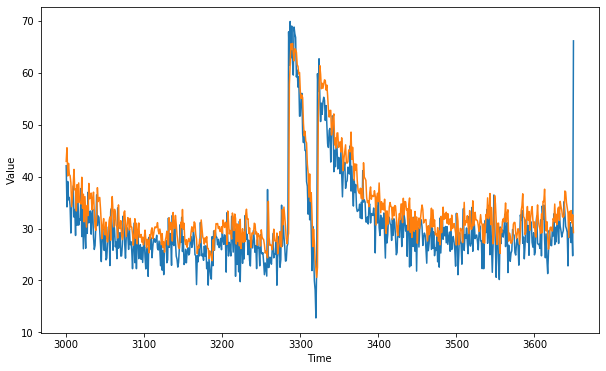

In [16]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.204211

<Figure size 432x288 with 0 Axes>

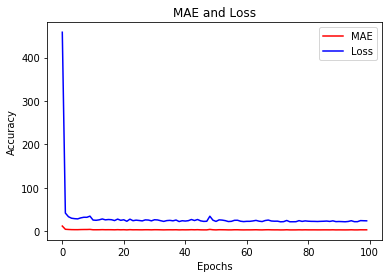

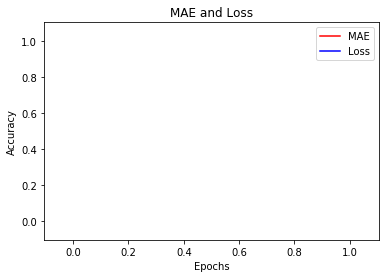

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()